In [1]:
from plotnine import *
import pandas as pd

In [2]:
results = pd.read_csv("benchmark_results.csv", sep='\t')

In [4]:
nbse_info = pd.read_csv("nbse_sets.csv")

In [29]:
data = results.merge(nbse_info, left_on=['name'], right_on=['set_name'])
data['mcs_size_to_atom_size'] = data['mcs_atoms'] / data['avg_atoms']
data.set_index(['name', 'optimizer_steps', 'optimizer_fine', 'optimizer_coarse', 'num_conformers', 'core', 'assemblies'])

,,,,,,,took,local_similarity,avg_conformer_tanimoto_dist,siena_rmsd,divide,set_name,most_atoms,most_bonds,least_atoms,least_bonds,mcs_atoms,num_mols,avg_atoms,mcs_bonds,avg_atoms_to_mcs,mcs_size_to_atom_size
name,optimizer_steps,optimizer_fine,optimizer_coarse,num_conformers,core,assemblies,,,,,,,,,,,,,,,,
3ke8,100,0.01,0.3,40,mcs,10,18,0.664895,0.629946,2.792387,True,3ke8,17,17,12,11,11,17,14.647,NaN,75.10%,0.751007
2vke,100,0.01,0.3,40,mcs,10,218,0.653470,0.613581,2.697748,True,2vke,42,45,31,34,22,12,33.522,NaN,65.63%,0.656285
1odn,100,0.01,0.3,40,mcs,10,303,0.569305,0.657672,3.152543,True,1odn,30,29,18,17,15,28,24.251,NaN,61.85%,0.618531
4dko,100,0.01,0.3,40,mcs,10,43,0.579109,0.458960,4.240663,True,4dko,30,33,23,24,15,13,26.077,NaN,57.52%,0.575220
3qqs,100,0.01,0.3,40,mcs,10,48,0.619915,0.311268,5.187691,True,3qqs,29,31,10,10,8,19,14.789,NaN,54.09%,0.540943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2bzs,100,0.01,0.5,10,mcs,1,379,0.489750,0.280324,4.841175,True,2bzs,37,41,11,11,6,40,19.176,NaN,31.29%,0.312891
3g5h,100,0.01,0.5,10,mcs,1,47,0.465171,0.388398,4.938331,True,3g5h,27,30,12,13,6,18,19.222,NaN,31.21%,0.312142
3tfu,100,0.01,0.5,10,mcs,1,126,0.308861,0.440039,6.178370,True,3tfu,28,30,11,12,6,13,19.462,NaN,30.83%,0.308293


In [19]:
data.describe()

,took,local_similarity,avg_conformer_tanimoto_dist,siena_rmsd,optimizer_coarse,optimizer_fine,num_conformers,assemblies,optimizer_steps,most_atoms,most_bonds,least_atoms,least_bonds,mcs_atoms,num_mols,avg_atoms,mcs_bonds,mcs_size_to_atom_size
count,63.000000,63.000000,63.000000,63.000000,63.000000,6.300000e+01,63.000000,63.000000,63.0,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,0.0,63.000000
mean,146.190476,0.506974,0.465856,4.098192,0.395238,1.000000e-02,25.714286,5.714286,100.0,31.968254,34.634921,15.380952,16.031746,9.396825,17.206349,22.920190,NaN,0.412766
std,164.064293,0.118941,0.128750,1.561374,0.100689,1.748657e-18,15.103331,4.530999,0.0,9.316943,10.519263,4.949515,5.668157,3.522003,6.426153,5.910129,NaN,0.114175
min,1.000000,0.000000,0.000000,0.000000,0.300000,1.000000e-02,10.000000,1.000000,100.0,12.000000,12.000000,9.000000,9.000000,4.000000,12.000000,10.769000,NaN,0.298533
25%,47.500000,0.444462,0.388475,2.905755,0.300000,1.000000e-02,10.000000,1.000000,100.0,26.500000,29.000000,11.500000,11.500000,7.000000,13.000000,19.199000,NaN,0.321633
50%,106.000000,0.506917,0.481823,3.955941,0.300000,1.000000e-02,40.000000,10.000000,100.0,30.000000,32.000000,14.000000,15.000000,9.000000,15.000000,21.560000,NaN,0.375834
75%,182.500000,0.580794,0.547738,5.159395,0.500000,1.000000e-02,40.000000,10.000000,100.0,37.000000,41.000000,18.000000,20.000000,11.000000,18.500000,27.115500,NaN,0.463246
max,900.000000,0.716516,0.734221,8.357425,0.500000,1.000000e-02,40.000000,10.000000,100.0,73.000000,80.000000,31.000000,34.000000,22.000000,40.000000,37.294000,NaN,0.751007


Local quality vs. Average Atoms

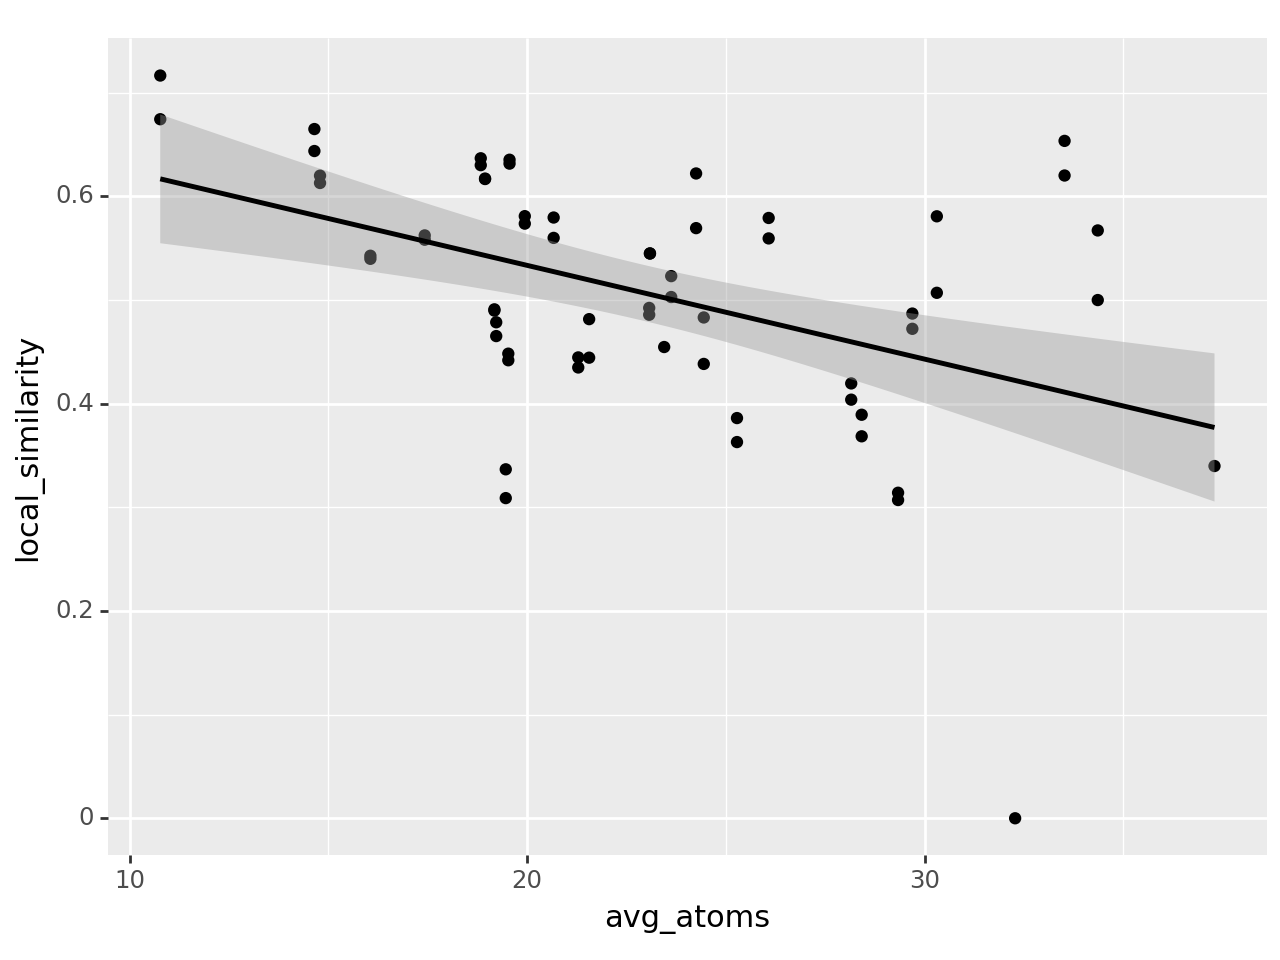

<Figure Size: (640 x 480)>

In [15]:
(ggplot(data=data, mapping=aes(x='avg_atoms', y='local_similarity')) 
 + geom_point()
 + geom_smooth(method='lm')
 )

Local quality vs. MCS size to average atoms


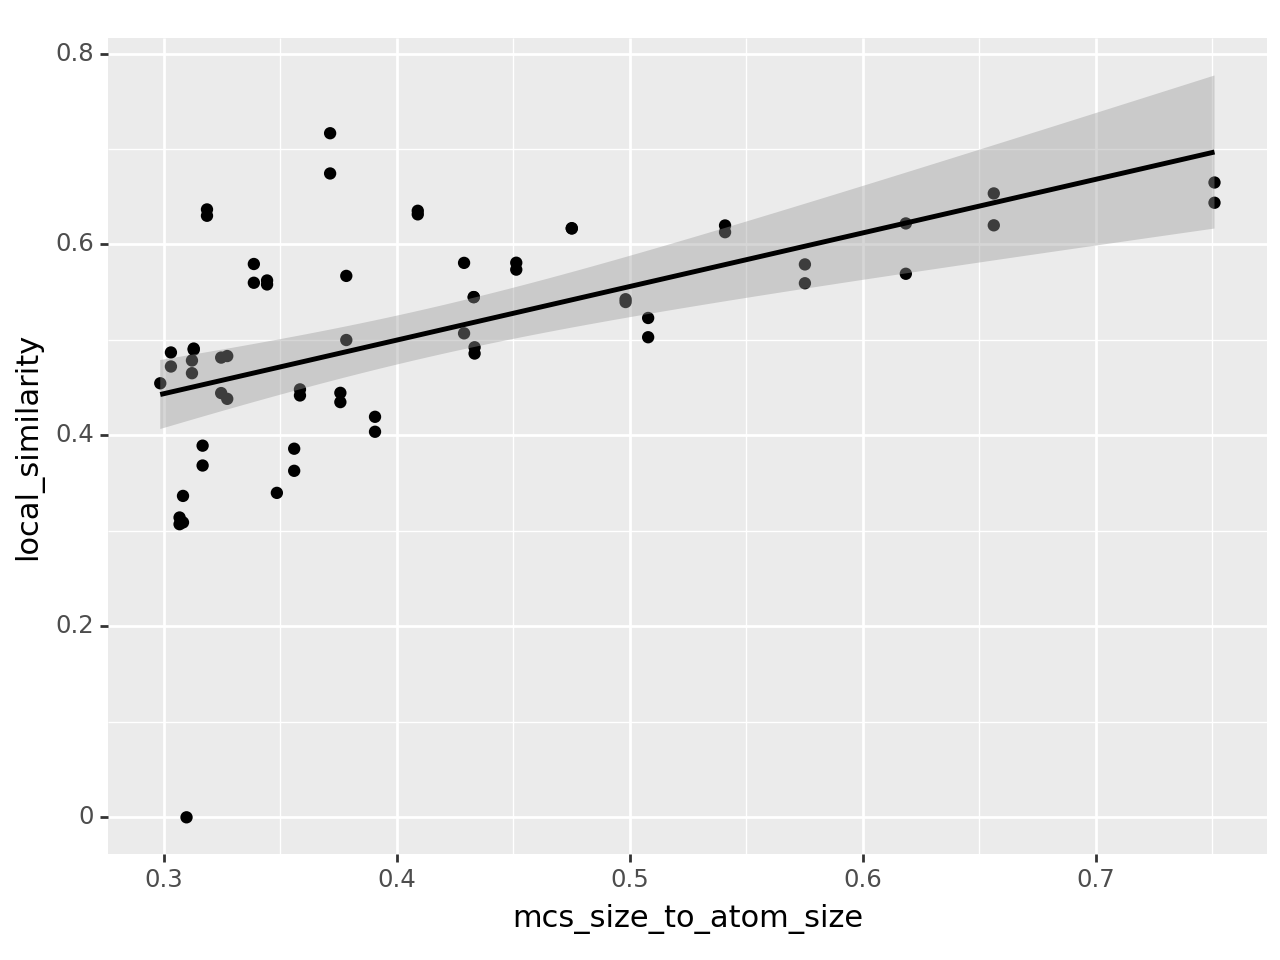

<Figure Size: (640 x 480)>

In [23]:
(ggplot(data=data, mapping=aes(x='mcs_size_to_atom_size', y='local_similarity'))
 + geom_point()
 + geom_smooth(method='lm')
 )

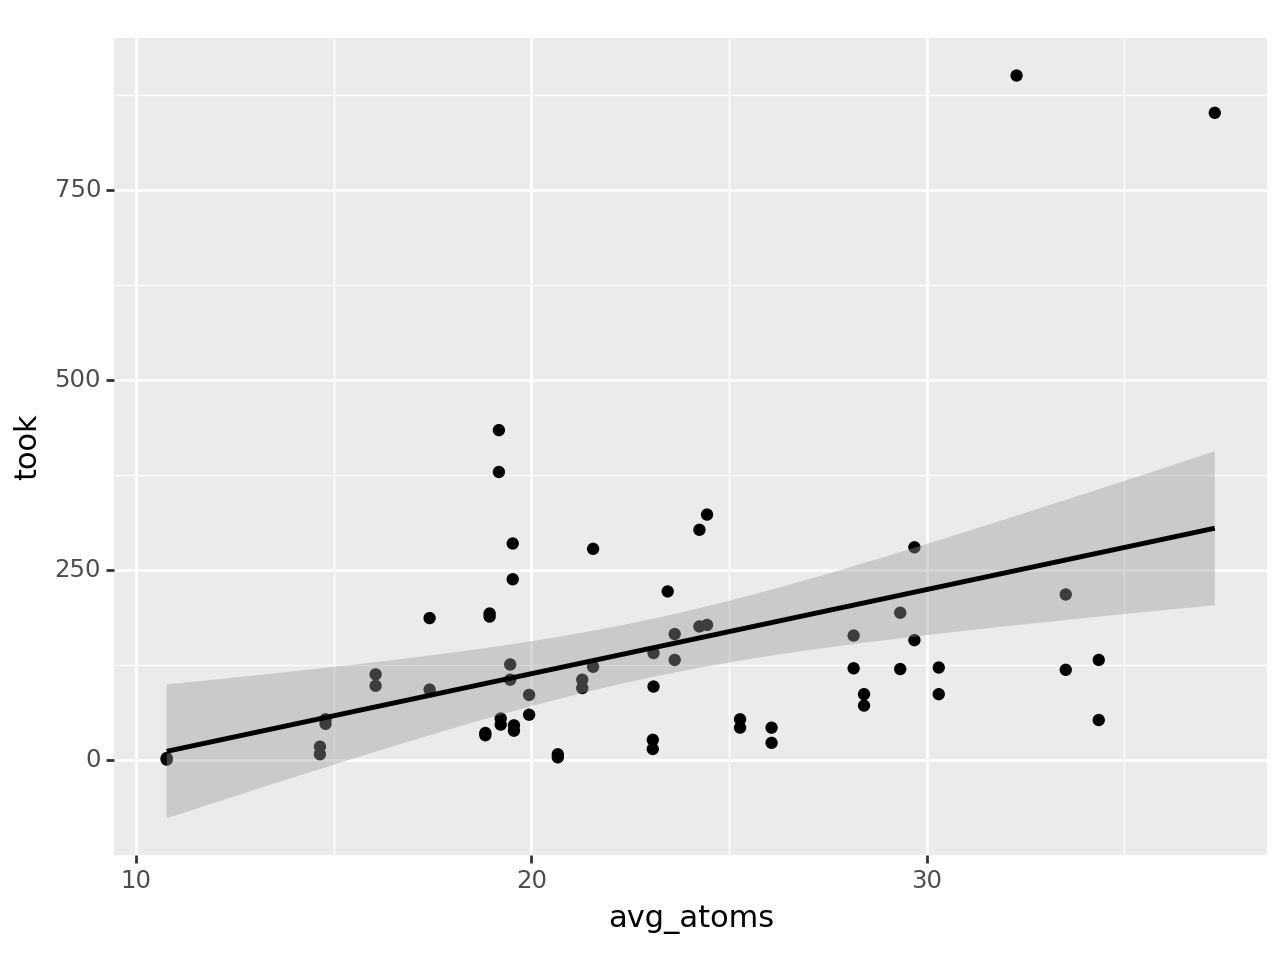

<Figure Size: (640 x 480)>

In [24]:
(ggplot(data=data, mapping=aes(x='avg_atoms', y='took'))
 + geom_point()
 + geom_smooth(method='lm')
 )


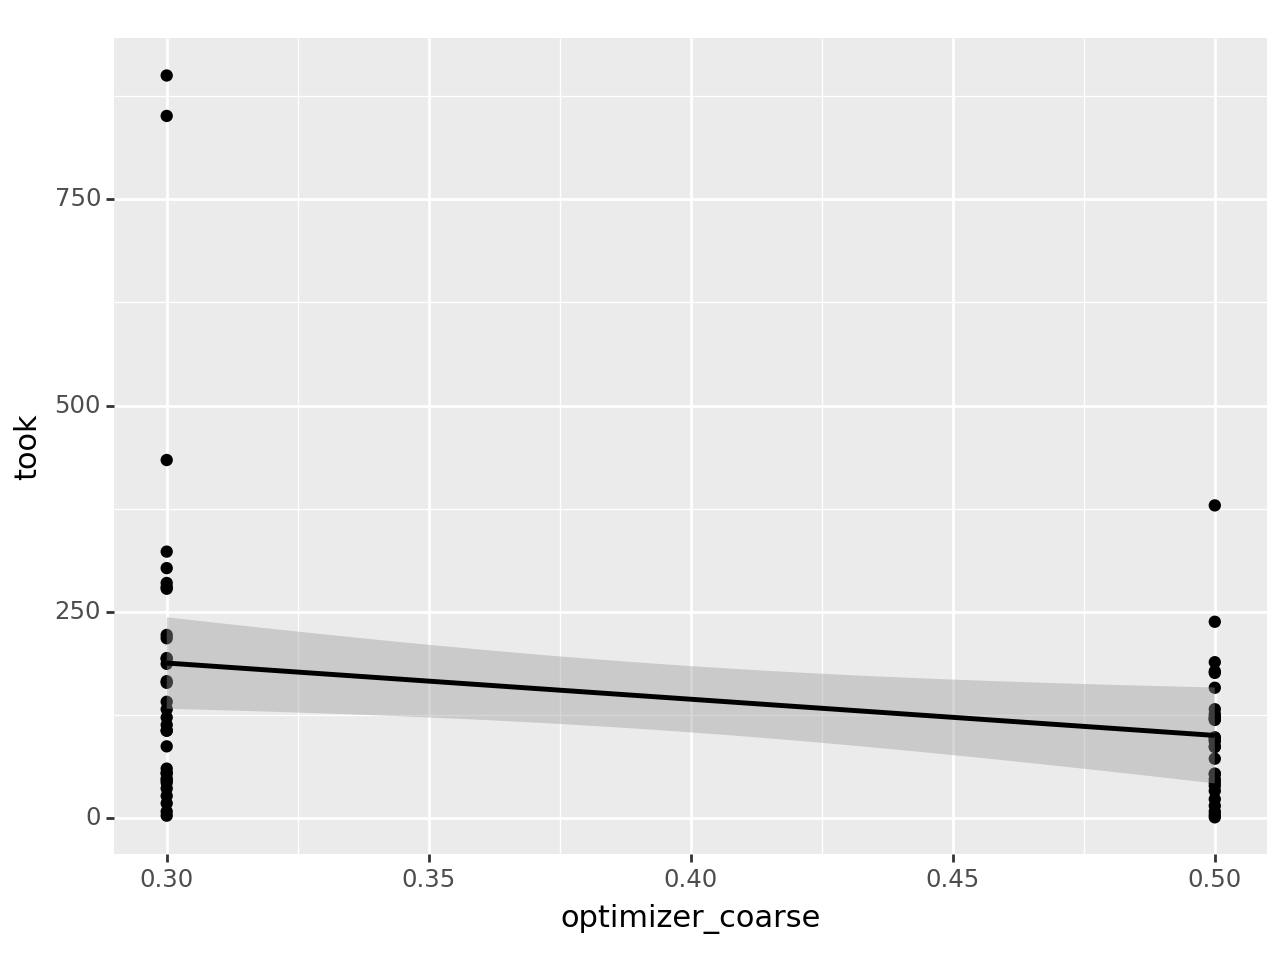

<Figure Size: (640 x 480)>

In [27]:
(ggplot(data=data, mapping=aes(x='optimizer_coarse', y='took'))
 + geom_point()
 + geom_smooth(method='lm')
 )